In [1]:
# Jason's implementation of directional algo
from algorithim import Params, Algorithm, Capon
from scipy.signal import find_peaks

import os
os.environ['DRJIT_LIBLLVM_PATH'] = '/usr/lib/x86_64-linux-gnu/libLLVM.so:'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import os # Configure which GPU

if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
    print(f"Using GPU {gpu_num}")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
print(f"Found {len(gpus)} GPUs")
if gpus:
    print(f"Found GPU: {gpus[0].name}")
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

2025-03-25 10:26:56.660182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742923616.670972 1182038 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742923616.674230 1182038 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 10:26:56.687333: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
jit_find_library(): Unable to load "/usr/lib/x86_64-linux-gnu/libLLVM.so:": /usr/lib/x86_64-linux-gnu/libLLVM.so:: cannot ope

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 1 GPUs
Found GPU: /physical_device:GPU:0


I0000 00:00:1742923618.416401 1182038 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, AntennaArray, Antenna

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid

def calculate_heading_rad(start, end):
    # Calculate the difference vector
    diff = np.array(end) - np.array(start)
    
    # Calculate the heading angle in radians
    heading = np.arctan2(diff[1], diff[0])
    
    return heading

def get_rss_from_csi(csi):
  # Compute CSI power (power per subcarrier)
  csi_power = tf.abs(csi)**2

  # Compute RSS per receiver-transmitter pair (sum over subcarriers)
  rss_per_rx_tx = tf.reduce_sum(csi_power, axis=-1)  # Sum over subcarriers

  # Convert RSS from linear scale (e.g., Watts) to dBm
  rss_per_rx_tx_dBm = 10 * tf.math.log(rss_per_rx_tx / 1e-3) / tf.math.log(10.0)

  return rss_per_rx_tx_dBm

def dbm_to_watts(dbm):
    return 10. ** ((dbm-30)/10)

def watts_to_dbm(watts):
    epsilon = 1e-10  # Small constant to avoid log(0)
    return 10 * np.log10(watts + epsilon) + 30

# # Multiple Antennas like ASUS Router
def get_antenna_positions(spacing):
    return np.array([[0.0, spacing / 2 + spacing , 0.0],
                     [0.0, spacing / 2, 0.0],
                     [0.0, -spacing / 2, 0.0],
                     [0.0, -spacing / 2 - spacing, 0.0]])

def flip_trajectory(data):
    # Vector from origin to the first and last points of each trajectory
    first_points = data[:, 0, :]  # Shape (1000, 3)
    last_points = data[:, -1, :]  # Shape (1000, 3)

    # Compute the dot product of the first and last points with respect to the origin
    dot_products = np.sum(first_points * last_points, axis=1)

    # Identify trajectories heading away from the origin (dot product > 0)
    away_from_origin = dot_products < 0

    # Flip the trajectories that are not heading away from the origin
    data[~away_from_origin] = data[~away_from_origin, ::-1, :]

    return data

In [4]:
data = np.empty(shape=(0, 20))
total_traj = 898
trajectories = np.load('trajectories_1000.npy')

for traj in range(total_traj):
    # List for dataset
    angles = []
    angle_profile_values = []
    rssi = []
    rssi_normalized = []

    SCENE_NAME = "canyon"
    IMAGE_FOLDER = f"images/{SCENE_NAME}"

    # Load integrated scene
    scene = load_scene(f"models/{SCENE_NAME}.xml") # Try also sionna.rt.scene.etoile

    # Configure antenna array for all transmitters
    scene.tx_array = PlanarArray(num_rows=1,
                                num_cols=1,
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern="iso",
                                polarization="V")

    antenna_positions = get_antenna_positions(0.03)
    antenna_array_angle = -175 # Default

    RelativeAntennas = AntennaArray(antenna=Antenna("dipole", "V"), 
                                positions=tf.Variable(antenna_positions.tolist()))

    # scene.tx_array = RelativeAntennas 
    scene.rx_array = RelativeAntennas

    # Create transmitter
    tx = Transmitter(name="tx",
                    position=[0., -10., 0.],
                    orientation=[np.radians(0),0,0])

    # Add transmitter instance to scene
    scene.add(tx)

    trajectories = flip_trajectory(trajectories)
    trajectory_index = traj
    num_steps = trajectories.shape[1]
    trajectory_steps =  np.arange(num_steps - 1)

    # start_color = np.array([1, 0, 0])  # Red
    # end_color = np.array([0, 0, 1]) 
    # colors = [start_color + (end_color - start_color) * i / (num_steps - 1) for i in range(num_steps)]

    # Calculate headings for the trajectory
    calculated_headings = []
    for i in trajectory_steps: #range(0, len(trajectories[0]) - 1):
        heading = calculate_heading_rad(trajectories[trajectory_index,i,:2], trajectories[trajectory_index,i + 1,:2])
        calculated_headings.append(heading)

    rxs = []
    for i, position in enumerate(trajectories[trajectory_index, np.arange(num_steps) ,:]):
        if i == (trajectories[0].shape[0] - 1):
            heading = calculated_headings[-1]
        else:
            heading = calculated_headings[i]
        rxs.append(Receiver(name=f"rx{i}",
                position=position,
                orientation=[heading,0,0]))   
        scene.add(rxs[i])
        # if trajectory_index == 0:
        #     print(f"Receiver {i} position: {position}")

    antenna_array_angle = np.radians(180) # heading

    scene.frequency = 2.14e9 #5.745 # in Hz; implicitly updates RadioMaterials

    scene.synthetic_array = False # If set to False, ray tracing will be done per antenna element (slower for large arrays)

    # Compute propagation paths
    paths = scene.compute_paths(max_depth=5,
                                num_samples=1e6,  # Number of rays shot into directions defined
                                                # by a Fibonacci sphere , too few rays can
                                                # lead to missing paths
                                los=True,  # Include Line-of-Sight paths
                                reflection=True,  # Include reflection paths
                                diffraction=True,  # Include diffraction paths
                                scattering=True,  # Include scattering paths
                                )

    paths.normalize_delays = False

    # Determine subcarrier frequencies
    rg = ResourceGrid(num_ofdm_symbols=1,
                    fft_size=52,
                    dc_null = True,
                    cyclic_prefix_length=20,
                    #   pilot_pattern = "kronecker",
                    #   pilot_ofdm_symbol_indices = [2, 8],
                    subcarrier_spacing=5e6) #30e3)

    frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)

    # get rss
    a, tau = paths.cir()

    csi = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)  # Non-normalized includes path-loss
   
    csi_reshaped = []
    for i in range(len(rxs)):
        csi_reshaped.append(np.array(csi[:,i,:,:,:,:,:]).reshape(4, 52))

    #Output: h_f ([batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size], tf.complex) – Channel frequency responses at frequencies
    block_rss = get_rss_from_csi(csi).numpy()[0, :, 0, 0, 0, 0]
    block_rss[np.isneginf(block_rss)] = -90
    rssi.append(block_rss[:-1])
    # Define range
    min_rss = -90
    max_rss = 0

    # Normalize values to 0-1
    normalized = (block_rss - min_rss) / (max_rss - min_rss)
    rssi_normalized.append(normalized[:-1])

    # # Define three colors
    # color_black = np.array([0, 0, 0])
    # color_red = np.array([1, 0, 0])
    # color_blue = np.array([0, 0, 1])
    # colors = []
    # for value in normalized:
    #     if value <= 0.5:
    #         # Scale between black and gray
    #         color = color_black + (color_red - color_black) * (value / 0.5)
    #     else:
    #         # Scale between gray and white
    #         color = color_red + (color_blue - color_red) * ((value - 0.5) / 0.5)
    #     colors.append(color)

    # Map normalized values to colors
    # 0-1 range is split into 3 intervals: [0, 1/3), [1/3, 2/3), [2/3, 1]
    # color_indices = np.digitize(normalized, bins=[1/3, 2/3], right=False)
    # mapped_colors = [colors[idx] for idx in color_indices]

    # for i, rx in enumerate(rxs):
    #     rx.color = colors[i]

    # Implementing Capon Algorithim
    params = Params(antenna_positions[:, :2])

    angle_tmp = []
    angle_profile_values_tmp = []
    for i in range(0, len(rxs) - 1):
        
        csi_tmp = tf.reshape(csi[:,i,:,:,:,:,:], [4, 52]) #  tf.reshape(csi[:,i,:,:,:,:,:], [1, -1])

        AOA, theta_samples, profile_norm = Capon(params, 155, 80, csi_tmp).evaluate()

        # This for when going towards transmitter
        profile_norm = np.roll(profile_norm, 180)
        # Capture three top peaks from bottom of profile (90-270 degrees)
        evaluation = np.array([profile_norm[90:270]])
        evaluation = evaluation.flatten() 
        peaks, _ = find_peaks(evaluation)
        peak_values = evaluation[peaks]
        angle_profile_values_tmp.append(np.pad(peak_values, (0, max(0, 3 - peak_values.shape[0])), mode='constant'))
        angle_tmp.append(np.pad(theta_samples[90:270][peaks], (0, max(0, 3 - theta_samples[90:270][peaks].shape[0])), mode='constant'))
        AOA = np.array([AOA])


    angles.append(angle_tmp)
    angle_profile_values.append(angle_profile_values_tmp)

    for i in range(0, len(rssi[0])):
        data = np.append(data, [rssi_normalized[0][i], angles[0][i][0], angles[0][i][1], angles[0][i][2], 
                                angle_profile_values[0][i][0], angle_profile_values[0][i][1], angle_profile_values[0][i][2],
                                trajectories[trajectory_index, i, 0], trajectories[trajectory_index, i, 1],
                                trajectories[trajectory_index, i, 2]])

/home/paolo/Documents/sionna/Sionna_dataset_generator/algorithim.py:195: RuntimeWarning: overflow encountered in matmul
  profile[i] = 1 / np.real(a.conj().T @ x)
/home/paolo/Documents/sionna/Sionna_dataset_generator/algorithim.py:202: RuntimeWarning: divide by zero encountered in log10
  profile_dBi = 10 * np.log10(profile_data / isotropic)


In [7]:
# print(rssi_normalized)
# print(angles)
# print(angle_profile_values)

# data = np.empty(shape=(0, 20))
# for i in range(0, len(rssi[0])):
#     data = np.append(data, [rssi_normalized[0][i], angles[0][i][0], angles[0][i][1], angles[0][i][2], angle_profile_values[0][i][0], angle_profile_values[0][i][1], angle_profile_values[0][i][2]])

# # angles = []
# # angle_profile_values = []
# # rssi = []
# # rssi_normalized = []

# print(data.shape[0]/7)
# print(rssi_normalized[0].shape)
print(data.reshape(total_traj, -1, 10).shape)
# print(data.reshape(total_traj, -1, 10)[:, :, 0])
# print(data[:,:,0:])


(898, 19, 10)


In [9]:
import wandb
wandb.login(key="ce83088be33d33e8cf0be4f78a8c7e9116cd4072") 
num_epochs = 10

wandb.init(
    project="NASA_DCG",  # change this to your project name
    config={
        "input_size": 7,
        "seq_len": 18,
        "hidden_size": 64,
        "num_layers": 1,
        "batch_size": 5,
        "epochs": num_epochs,
        "lr": 1e-3
    }
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/paolo/.netrc
wandb: Currently logged in as: patorrad (sensors_lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

data = data.reshape(total_traj, 19, 10) 

# Define a custom dataset
class TrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        seq = self.data[idx]  # shape (19, 7)
        input_seq = seq[:-1]         # (18, 7)
        target_value = seq[-1, 0]    # scalar: next-step value of first feature
        return input_seq, target_value


# Wrap your tensor in the dataset
dataset = TrajectoryDataset(torch.tensor(data, dtype=torch.float32))

# Split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)


In [19]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_size=7, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # output single value per sequence

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)     # hn: (num_layers, batch, hidden)
        last_hidden = hn[-1]             # (batch, hidden_size)
        output = self.fc(last_hidden)    # (batch, 1)
        return output.squeeze(1)         # return (batch,) shape

In [20]:
model = LSTMRegressor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    for input_seq, target_val in train_loader:
        input_seq = input_seq[:, :, :7]
        output = model(input_seq)
        loss = criterion(output, target_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Log training loss
    wandb.log({"train_loss": loss.item(), "epoch": epoch})

    # Optional test loop
    rssi_ground_truth = []
    rssi_predicted = []
    pos = []
    test = []
    model.eval()
    with torch.no_grad():
        test_losses = []
        for input_seq, target_val in test_loader:
            pos.append(input_seq[:, -1, 7:])
            input_seq = input_seq[:, :, :7]
            test.append(target_val)
            test_output = model(input_seq)
            rssi_ground_truth.append(target_val.numpy())
            rssi_predicted.append(test_output.numpy())
            test_loss = criterion(test_output, target_val)
            test_losses.append(test_loss.item())
        avg_test_loss = sum(test_losses) / len(test_losses)

    wandb.log({"test_loss": avg_test_loss, "epoch": epoch})
    model.train()

torch.save(model.state_dict(), "NASA_DCGR.pt")



In [21]:
print(f"Pos {pos[0].shape}")
print(f"Ground truth {rssi_ground_truth[0]}")
print(f"Ground predicted {rssi_predicted[0]}")
print(test_loader.dataset.__getitem__(3)[0].shape)
num_batches = len(test_loader.dataset)
print(f"Total batches: {num_batches}")

# import h5py
# with h5py.File('data.h5', 'w') as hf:
#     hf.create_dataset("data",  data=data)

Pos torch.Size([100, 3])
Ground truth [0.8887029  0.86154693 0.6850995  0.9072892  0.7743308  0.83965015
 0.6709318  0.77093846 0.8251765  0.83933777 0.7216507  0.7789905
 0.39341778 0.41202977 0.8804529  0.7859404  0.82698786 0.6090225
 0.80968136 0.73954046 0.31820044 0.73273706 0.8390336  0.4063031
 0.89923996 0.7167443  0.12168197 0.8464918  0.8677272  0.6226512
 0.90492564 0.8804383  0.8890017  0.6828407  0.8572007  0.5771587
 0.82423717 0.8323364  0.7785192  0.9043838  0.89726967 0.71736884
 0.8488926  0.56423986 0.7832528  0.7324684  0.5697894  0.8176727
 0.73918134 0.54685426 0.40785226 0.85985523 0.7660849  0.8147905
 0.8238325  0.83404475 0.25324327 0.8255798  0.7836934  0.56102085
 0.93864137 0.81728566 0.78890145 0.58439714 0.78291404 0.51701593
 0.36427084 0.73533535 0.54836124 0.8366701  0.8315777  0.79408103
 0.679079   0.7013285  0.50986713 0.88109654 0.6976266  0.81091225
 0.7949311  0.8221068  0.838673   0.40129992 0.92805725 0.6914653
 0.5685362  0.6090383  0.7385345

In [23]:
import trimesh
# mesh = trimesh.load_mesh("models/lunar_mesh_ex.ply")
mesh = trimesh.load_mesh("models/canyon.ply")
import numpy as np

radius = 0.5  # small radius for visibility

markers = []
for rssi, pose in zip(rssi_ground_truth[0], pos[0]):
    marker = trimesh.creation.icosphere(radius=radius, color=[rssi, 0, (1 - rssi), 1]) 
    marker.apply_translation(pose)
    markers.append(marker)

scene = trimesh.Scene()
scene.add_geometry(markers)
scene.add_geometry(mesh)
scene.show()
# mesh.show()

/tmp/ipykernel_1182038/3710131881.py:10: DeprecationWarning: `icosphere(color=...)` is deprecated and will be removed in June 2024: replace with Trimesh constructor kewyword argument `icosphere(face_colors=...)`
  marker = trimesh.creation.icosphere(radius=radius, color=[rssi, 0, (1 - rssi), 1])


In [ ]:
import trimesh
# mesh = trimesh.load_mesh("models/lunar_mesh_ex.ply")
mesh = trimesh.load_mesh("models/canyon.ply")
import numpy as np

point = np.array([.0, .0, .0])  # example point
radius = 0.5  # small radius for visibility

markers = []
for rssi, pose in zip(rssi_predicted[0], pos[0]):
    marker = trimesh.creation.icosphere(radius=radius, color=[rssi, 0, (1 - rssi), 1])  # red color
    marker.apply_translation(pose)
    markers.append(marker)

scene = trimesh.Scene()
scene.add_geometry(markers)
scene.add_geometry(mesh)
scene.show()
# mesh.show()

167.68398374319077
173.40501755475998
164.06157732009888
156.41397088766098


/tmp/ipykernel_1145228/720426925.py:12: DeprecationWarning: `icosphere(color=...)` is deprecated and will be removed in June 2024: replace with Trimesh constructor kewyword argument `icosphere(face_colors=...)`
  marker = trimesh.creation.icosphere(radius=radius, color=[rssi, 0, (1 - rssi), 1])  # red color


ValueError: x and y must have same first dimension, but have shapes (19,) and (1,)

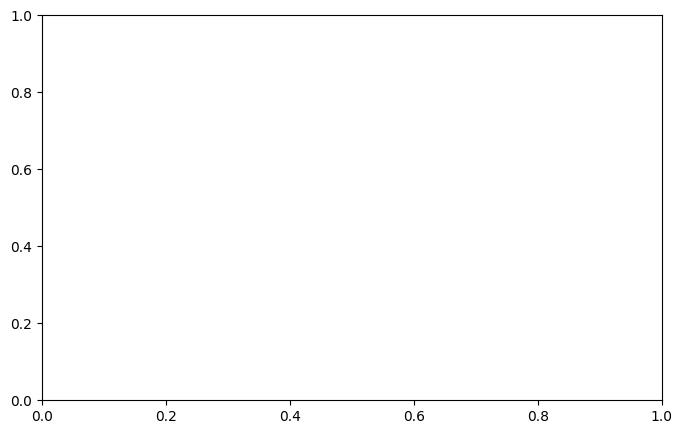

In [13]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Get a test batch
test_x, test_y = next(iter(test_loader))  # Get one batch from the DataLoader
test_x, test_y = test_x.to('cpu'), test_y.to('cpu')  # Move to GPU if available

# Predict using the model
model.eval()
with torch.no_grad():
    predictions = model(test_x)  # Shape: (batch_size, 19)

# Move predictions and real values back to CPU for visualization
predictions = predictions.cpu().numpy()
test_y = test_y.cpu().numpy()

# Select a sample from the batch to visualize
sample_idx = 0  # Choose the first trajectory in the batch
time_steps = np.arange(19)  # Time step indices

plt.figure(figsize=(8, 5))
plt.plot(time_steps, test_y[sample_idx], label="Ground Truth", marker="o")
plt.plot(time_steps, predictions[sample_idx], label="Predicted", marker="x")

plt.xlabel("Time Steps")
plt.ylabel("Target Value (y)")
plt.title(f"Trajectory Prediction Comparison (Sample {sample_idx})")
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute MSE (Lower is better)
mse = mean_squared_error(test_y.flatten(), predictions.flatten())
mae = mean_absolute_error(test_y.flatten(), predictions.flatten())

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")



